# Softmax
- 数据集：Fashion MNIST
- 批量大小：256

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size) 

# 初始化模型参数
- 平展图片向量：(1, 28, 28) —> 784
- 因为输出有10个类别，输入有784个，所以权重 $\bf w\in\mathbb{R}^{784\times 10}$ ，偏置 $b\in \mathbb{R}^{1\times 10}$ 。和线性回归相同，用正态分布初始化 $\bf w$ ，偏置 $b$ 置为0


In [4]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

# 定义softmax操作
由于softmax的分母涉及到求和操作，因此需要回顾sum()的用法。
sum()可以沿着指定轴，对该轴上的元素进行求和，并且可以通过指定 `keepdim=True` 来保持原张量的轴数不变。
而对于softmax函数，计算流程如下：
1. 计算每个分量（项）的幂
2. 对每一行求和
3. 将对应项的幂除以和，即规范化，确保结果为1

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition # 用到了广播机制，因为sum求和会导致轴长度为1，但是维度并没有被折叠

上述实现从数学角度看并没有问题，但是从计算机内部角度来看，矩阵中很大或是很小的元素会造成数值上溢或数值下溢，需要进行处理

# 定义模型
定义好softmax函数后，可以定义softmax回归模型


In [6]:
def net(X):
    '''softmax模型，先将输入展开，再加权求和'''
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)

# 定义损失函数
交叉熵损失函数：用真实标签得到预测概率的负对数似然
不使用for迭代循环，而是直接使用运算符进行 *矢量化加速* 。

In [11]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [30]:
def cross_entropy(y_hat,y):
    '''计算交叉熵损失函数，不使用for，而是以选择元素的方式'''
    # y_hat输出是n*d，因为是软标签，y是1*n，因为是真实值，硬标签
    return -torch.log(y_hat[range(len(y_hat)),y]) # y_hat[[0,1],y]可以看成一个1*2的向量，第一个元素是y_hat[0,y[1]]，第二个元素是y_hat[1,y[1]]
# 所以log()里的式子可以看成在y_hat中依次选择数据的真实标签的输出概率，求负对数，最后求和

# 分类精度
直接优化精度很困难，因为判断正确与否是看分的类别是否正确，非0即1，不可导，但是精度又是重要的衡量指标，所以需要重点关注。
计算精度 `accuracy` 的方法：$accuracy = count(y_hat == y)$
由于 `==` 很敏感，需要将 `y_hat` 的数据类型转化为与 `y` 一致后再进行比较

In [8]:
def accuracy(y_hat,y):
    '''计算预测正确的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1: # y_hat是矩阵
        y_hat = y_hat.argmax(axis=1) # 将概率最大的类别作为预测结果
    
    cmp = y_hat.type(y.dtype) == y # 非0即1
    return float(cmp.type(y.dtype).sum()) # 计算1的个数

In [12]:
accuracy(y_hat,y) / len(y)

0.5

上述计算精度适用于任何模型评估精度

先定义了一个累加器，用于对多个变量进行累加。

在这里一共有2个变量（1）正确预测数（2）预测总数。随着时间推移，二者也不断累加

In [15]:
class Accumulator:
    def __init__(self,n):
        self.data = [0,0] * n
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data = [0,0] * len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

In [18]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval() # 将模型设置为评估模式！
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [19]:
# 由于随机初始化权重，偏置置0，一共10个类别那么现在的精度应该大约是0.1
evaluate_accuracy(net,test_iter)

0.0955

# 训练
流程：
- 初始化参数 $\bf w$ $b$
- 重复更新参数（遍历epoch）
    - 设置为训练模式
    - 遍历每个批次
        - 前向传播
        - 计算损失
        - 清空梯度 updater.zero_grad(
        - 计算梯度 l.mean().backward()
        - 更新参数 updater.step()

In [24]:
def train_epoch(net,train_iter,loss,updater):
    '''one eopch'''
    # 将模型设置为训练模型
    if isinstance(net,torch.nn.Module):
        net,train()
    metric = Accumulator(3) # 损失总和 准确度综合和 样本数
    for X,y in train_iter:
        y_hat = net(X) # 前向传播得到结果
        l = loss(y_hat,y) # 计算损失
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad() # 清空梯度
            l.mean().backward() # 计算梯度
            updater.step() # 更新参数
        else:
            # 使用定制的优化器
            l.sum().backward()
            updater(X.shape[0])
        metric.add(l.sum(),accuracy(y_hat,y),y.numel())
    # 返回损失值与训练精度
    return metric[0] / metric[2],metric[1] / metric[2]

动画绘制函数

In [23]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [27]:
def train(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=["train loss","train acc","test acc"])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch + 1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics
    assert train_loss<0.5,train_loss
    assert train_acc<=1 and train_acc>0.7,train_acc
    assert test_acc<=1 and test_acc>0.7,test_acc

In [34]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

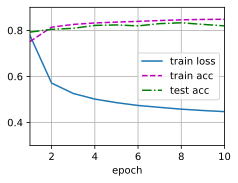

In [35]:
num_epochs = 10
train(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

# 预测
训练模型已经完成，接下来要对图像进行分类

In [38]:
def predict_img(net,test_iter,n=6):
    for X,y in test_iter:
        #y_hat = net(X) # 前向传播
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])


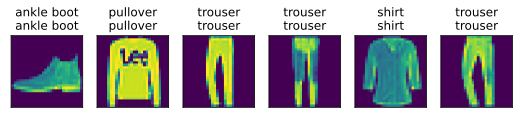

In [39]:
predict_img(net,test_iter)

# Discussion
- softmax存在的问题：
    1. 对数据敏感，若是某一个分量太大，会导致softmax的结果很不平衡，不利于维持训练稳定
    2. cross-entropy仅支持正数，有局限性
但是可以通过在进行softmax之前先对数据做归一化/标准化处理来解决
- 需要注意的是，输出中概率最大的不一定就是最优解，比如医疗诊断场景下，即使概率最大，但是由于输入特征有限并且病情判断错综复杂，需要结合多方面考虑，因此不是概率最大就一定是最终解
- 若是用softmax去预测下一词，由于词表中单词数目很多，这会造成分母很大，从而导致softmax处理后的结果很小，梯度消失，不利于训练稳定


- **from DeepSeek**
- softmax存在问题
    1. 数值溢出，超出浮点数表示范围
    2. 数值不稳定，就算没有溢出，如果数值很大，也会导致分母很大，概率值接近于0，导致训练不稳定
但是可以通过减去输入最大值来解决，即 $exp(x_i-max({\bf x}))$
- 直接实现 `cross-entropy` 可能存在的问题：
    1. 对数定义域：若是 $y_i$ 接近于0，其对数接近于负无穷，导致数值不稳定或计算错误
    2. 若是个别概率的预测概率为0，而真实标签为1，计算 $log0$ 会导致计算错误
可以通过在对数内加上一个很小的常数实现 $L=-\sum_{i=1}^n \hat{y}log(\hat{y}^{(i)}+\epsilon)$ ，或者直接使用 `torch` 提供的 `nn.CrossEntropyLoss` 计算。
- 概率最大的标签在大多数情况下是合理的，但不一定总是最优解，比如医疗诊断场景，或是代价敏感任务（不同类别错分的代价不同，此时需要结合代价矩阵优化决策）
可以通过（1）具体任务调整阈值，而非简单地选择概率最大的类别（2）使用代价敏感学习或自定义损失函数，以反映误分类的代价
- 单词分类任务中 `softmax` 的局限性
    1. 计算效率低
    2. 梯度稀疏，只有少部分单词的梯度是非0的，导致梯度更新效率低
    3. 内存占用高，浪费多，因为假设单词表长度为 `n` ，需要存储 `n` 维的输出向量，但是其中很多分量都是0或者接近0，空间浪费严重
可以（1）层次化softmax，将单词表组织成树结构（2）负采样，只对少数负数样本（非目标单词）计算损失，减少计算量（3）基于采样的方法，如噪声对比估计 `NCE` 或自适应softmax，进一步优化计算效率